In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 as cv
import numpy as np
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Activation, Add, ZeroPadding2D,AveragePooling2D
from tensorflow.keras.preprocessing.image import load_img,img_to_array

2025-01-01 18:16:26.471853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-01 18:16:26.547944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-01 18:16:26.570788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 18:16:26.723083: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-01 18:16:28.194950: W tensorflow/compiler/tf2

In [3]:
!nvidia-smi

Wed Jan  1 18:16:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.51.01              Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070        On  |   00000000:01:00.0  On |                  N/A |
|  0%   42C    P8             14W /  200W |    1856MiB /  12282MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Sample Image To Track Progress Through Pipeline

In [4]:
SAMPLE_IMAGE = 'dog.0.jpg'
SAMPLE_IMAGE_2 = 'cat_0.jpg'

Image Dimensions: (1, 800, 800, 3)


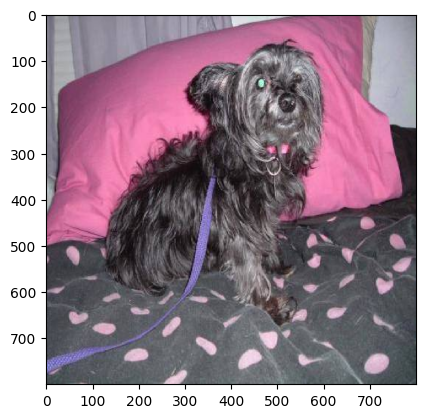

In [5]:
img_pre = load_img(SAMPLE_IMAGE,target_size=(800,800))
img_pre = img_to_array(img_pre)
img_pre = np.divide(img_pre,255.0)
plt.imshow(img_pre)
img_pre = np.expand_dims(img_pre,axis=0)
print(f'Image Dimensions: {img_pre.shape}')

Image Dimensions: (1, 800, 800, 3)


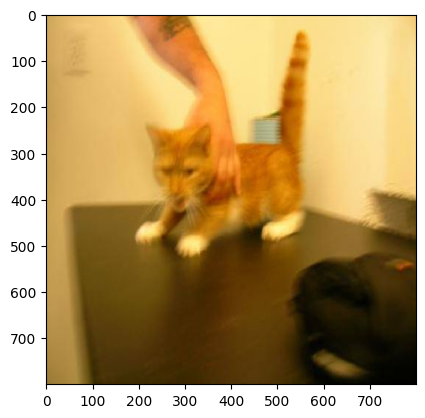

In [6]:
img_pre_2 = load_img(SAMPLE_IMAGE_2,target_size=(800,800))
img_pre_2 = img_to_array(img_pre_2)
img_pre_2 = np.divide(img_pre_2,255.0)
plt.imshow(img_pre_2)
img_pre_2 = np.expand_dims(img_pre_2,axis=0)
print(f'Image Dimensions: {img_pre_2.shape}')

# Steps for Faster R-CNN Architecture

1. **Create Backbone Network**
   - Select a pre-trained CNN (e.g., VGG16, ResNet) for feature extraction.
2. **Generate Region Proposals with RPN**
   - Define anchor boxes of various sizes and aspect ratios.
   - Use a CNN to predict objectness scores and refine anchor box coordinates.
   - Compute RPN loss (classification and regression).

3. **RoI Pooling Layer**
   - Select top N region proposals from RPN.
   - Apply RoI pooling to transform proposals into fixed-size feature maps.

4. **Classification and Bounding Box Regression**
   - Pass pooled features through fully connected layers.
   - Predict object classes and bounding box offsets.
   - Compute classification and regression loss.

5. **Combine Losses**
   - Combine losses from RPN and classification/regression branches into a total loss.

6. **Training Process**
   - Implement backpropagation and update weights using an optimizer (e.g., Adam, SGD).
   - Train the model using mini-batches.

7. **Post-Processing**
   - Apply Non-Maximum Suppression (NMS) to remove duplicate bounding boxes.
   - Filter predictions based on confidence scores.

8. **Evaluation**
   - Evaluate the model using metrics like mean Average Precision (mAP).

9. **Inference**
   - Prepare the model for inference and load weights.
   - Visualize results with bounding boxes and labels on input images.


## 1. **Create Backbone Network**
   - Select a pre-trained CNN (e.g., VGG16, ResNet) for feature extraction.

In [7]:
class VGG_16_NFCL(tf.keras.Model):
    def __init__(self):
        super(VGG_16_NFCL, self).__init__()

        # Layer 1
        self.conv_1a = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name="conv_1A")
        self.conv_1b = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name="conv_1B")
        self.max_pool_1a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool1A")

        # Layer 2
        self.conv_2a = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name="conv_2A")
        self.conv_2b = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name="conv_2B")
        self.max_pool_2a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool2A")

        # Layer 3
        self.conv_3a = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name="conv_3A")
        self.conv_3b = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name="conv_3B")
        self.conv_3c = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name="feature_map_1")
        self.max_pool_3a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool3A")

        # Layer 4
        self.conv_4a = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_4A")
        self.conv_4b = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_4B")
        self.conv_4c = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="feature_map_2")
        self.max_pool_4a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool4A")

        # Layer 5
        self.conv_5a = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_5A")
        self.conv_5b = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_5B")
        self.conv_5c = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="feature_map_3")

    def call(self, input_tensor, training=False, mask=None):
        x = self.conv_1a(input_tensor)
        x = self.conv_1b(x)
        x = self.max_pool_1a(x)

        x = self.conv_2a(x)
        x = self.conv_2b(x)
        x = self.max_pool_2a(x)

        x = self.conv_3a(x)
        x = self.conv_3b(x)
        x = self.conv_3c(x)
        x = self.max_pool_3a(x)

        x = self.conv_4a(x)
        x = self.conv_4b(x)
        x = self.conv_4c(x)
        x = self.max_pool_4a(x)

        x = self.conv_5a(x)
        x = self.conv_5b(x)
        x = self.conv_5c(x)

        return x

    def build_graph(self,input_size):
        x = tf.keras.layers.Input(shape=(input_size[0],input_size[1],3))
        return tf.keras.Model(inputs=[x],outputs=self.call(x))

    def build(self,input_shape):
        super().build(input_shape)
        self.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')


In [8]:
batch_input = np.vstack((img_pre, img_pre_2))

In [9]:
batch_input.shape

(2, 800, 800, 3)

In [10]:
vgg_backbone = VGG_16_NFCL()

# Generate Feature Maps From Backbone
feature_map = vgg_backbone.call(batch_input)

I0000 00:00:1735773396.079047     626 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735773396.253176     626 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735773396.253226     626 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735773396.255105     626 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735773396.255170     626 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [11]:
# Build Graph For Reference
vgg_backbone.build_graph(input_size=[800,800]).summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 800, 800, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1A (Conv2D)                │ (None, 800, 800, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1B (Conv2D)                │ (None, 800, 800, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1A (MaxPooling2D)       │ (None, 400, 400, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2A (Conv2D)                │ (None, 400, 400, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2B (Conv2D)                │ (None, 400, 400, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool2A (MaxPooling2D)       │ (None, 200, 200, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3A (Conv2D)                │ (None, 200, 200, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3B (Conv2D)                │ (None, 200, 200, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_map_1 (Conv2D)          │ (None, 200, 200, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool3A (MaxPooling2D)       │ (None, 100, 100, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4A (Conv2D)                │ (None, 100, 100, 512)  │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4B (Conv2D)                │ (None, 100, 100, 512)  │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_map_2 (Conv2D)          │ (None, 100, 100, 512)  │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool4A (MaxPooling2D)       │ (None, 50, 50, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5A (Conv2D)                │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5B (Conv2D)                │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_map_3 (Conv2D)          │ (None, 50, 50, 512)    │     2,359,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
for layers in vgg_backbone.layers:
  if "feature_map" in layers.name:
    filters,bias = layers.get_weights()
    print(layers.name,filters.shape)

feature_map_1 (3, 3, 256, 256)
feature_map_2 (3, 3, 512, 512)
feature_map_3 (3, 3, 512, 512)


In [13]:
print(f'Backbone Feature Map Shape: {feature_map.shape}')

Backbone Feature Map Shape: (2, 50, 50, 512)


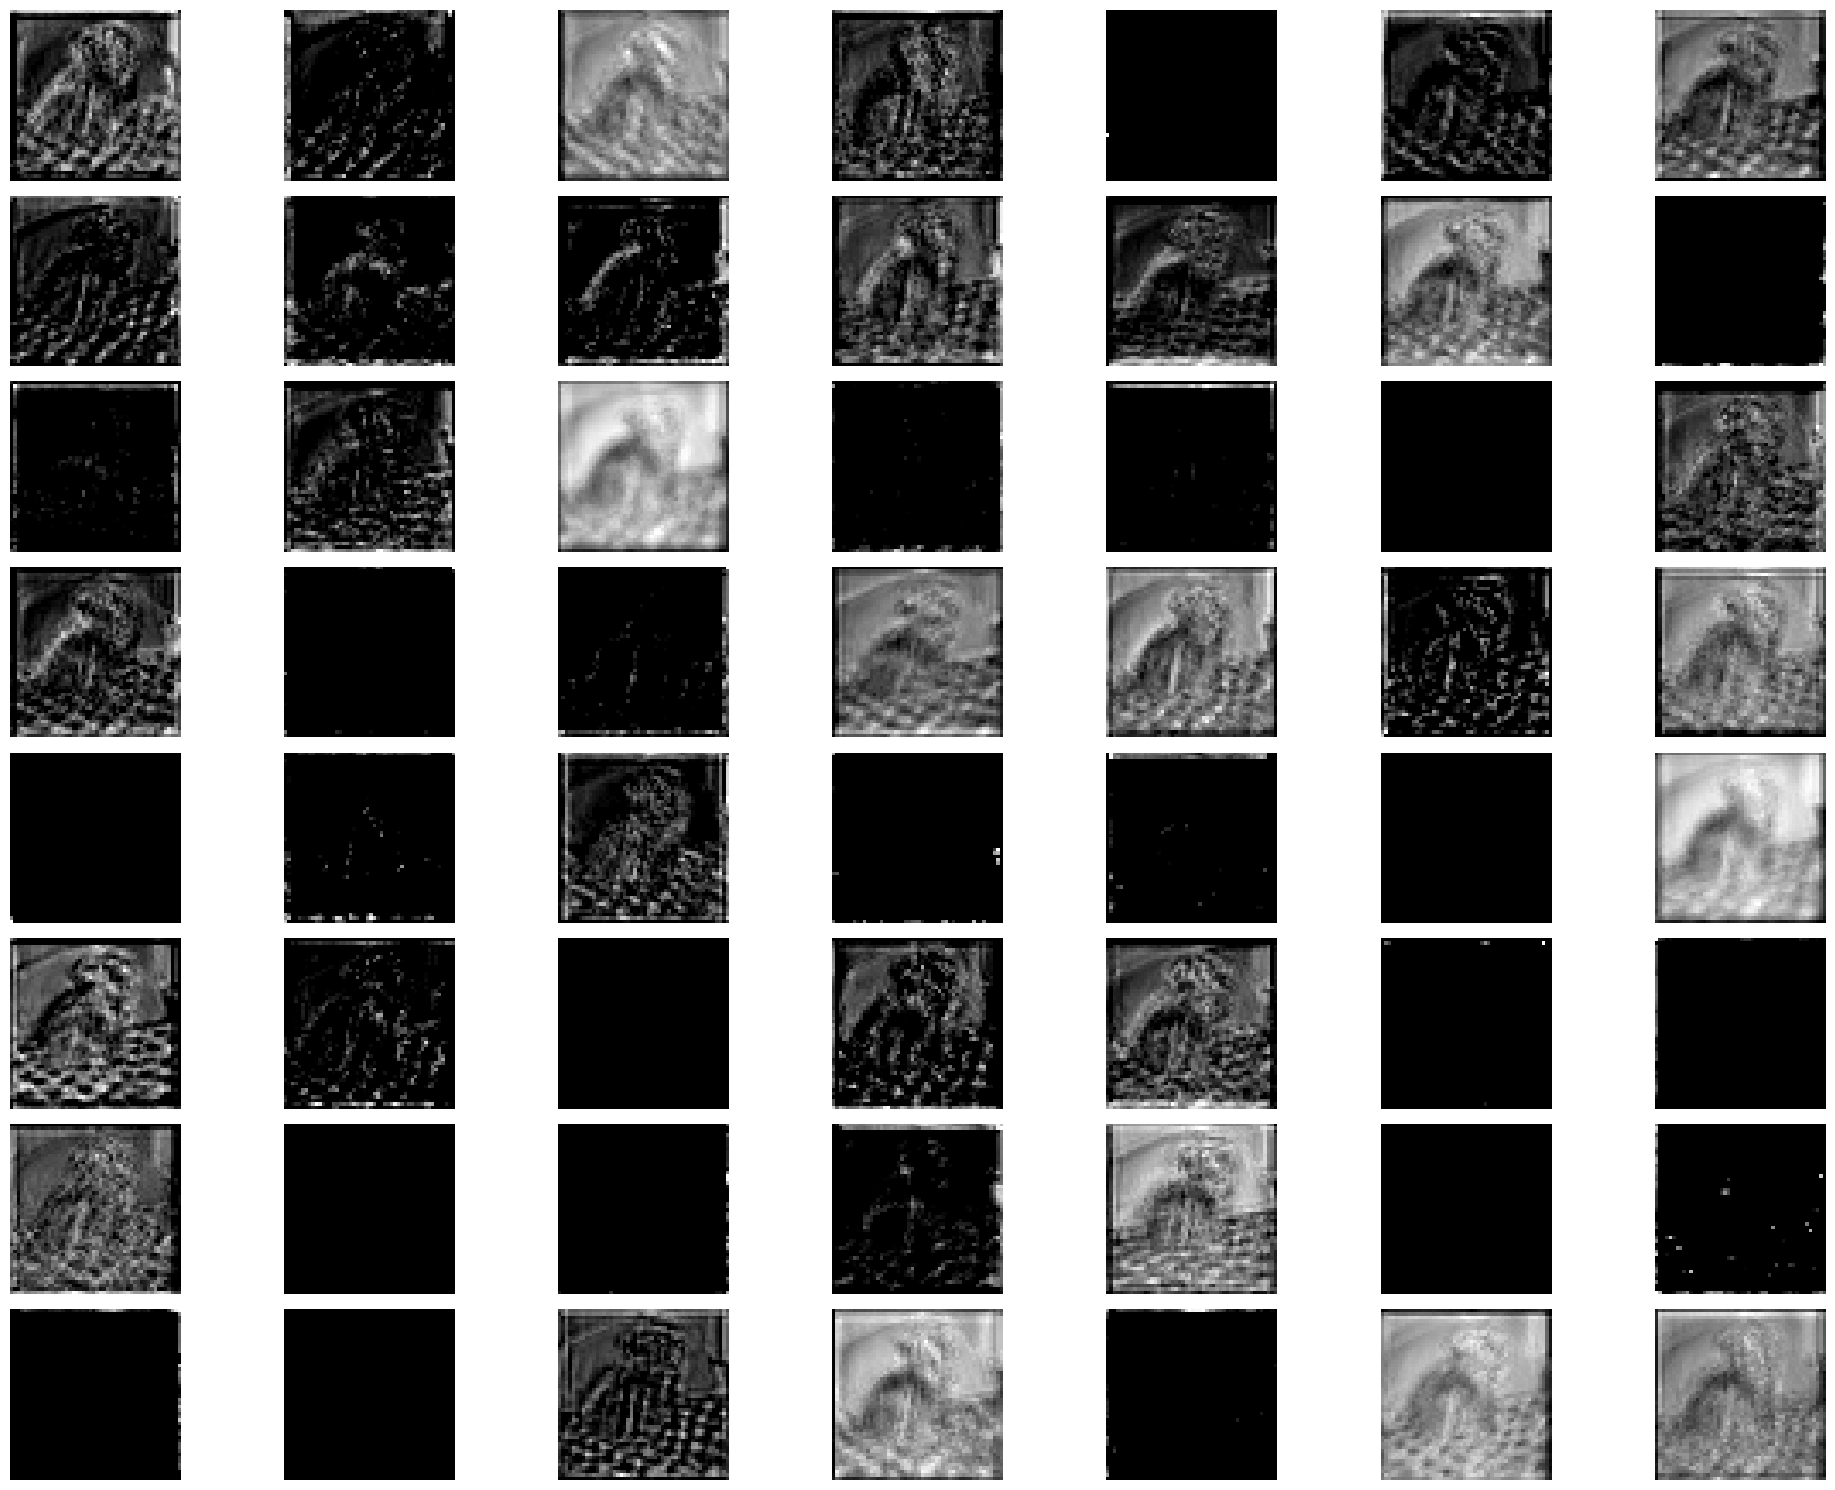

In [14]:
num_features = feature_map.shape[3]
max_features_to_display = min(num_features, 56)
fig = plt.figure(figsize=(20, 15))


for index in range(max_features_to_display):
    plt.subplot(8, 7, index + 1)
    plt.imshow(np.clip(feature_map[0, :, :, index], 0, 1), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## 2. **Generate Region Proposals with RPN**
   - Define anchor boxes of various sizes and aspect ratios.
   - Use a CNN to predict objectness scores and refine anchor box coordinates.
   - Compute RPN loss (classification and regression).

### Define Anchor boxes of various sizes and aspect ratios
<ul>
    <li> Calculate Anchor Centers</li>
    <li> Create Anchor Box</li>
    <li> Create Anchor Box Of Different Aspect Ratios, Scales</li>
</ul>

In [15]:
def get_number_of_anchor_points(feature_map) -> (int, int, int):
    """
    Calculates the number of anchor points (centers) for the the feature_map

    Parameters
    ----------
    feature_map: Feature Map created by CNN backbone
    ----------

    Returns
    ----------
    Tuple[int, int, int]
        Tuple of the Number of anchor points, the X-axis size of the feature map, the Y-axis size of the feature map
    ----------
    """

    if len(feature_map.shape) != 4:
        raise ValueError("Input must be a 4D tensor with shape (batch_size, height, width, channels)")
    
    # Get the Shape of the Image (WxH)
    _, axis_1, axis_2, _ = feature_map.shape
    # Total Number of Anchor Points Possible is WxH
    anchors = axis_1 * axis_2
    # Return Tuple of Number of Anchors, Axis Sizes
    return anchors, axis_1, axis_2

In [16]:
number_of_anchors,x_axis,y_axis = get_number_of_anchor_points(feature_map)
print(f'Number Of Anchor Points (Centers) To Be Placed On Feature Map: {number_of_anchors}')

Number Of Anchor Points (Centers) To Be Placed On Feature Map: 2500


In [17]:
def calculate_anchor_stride(original_size, feature_map_size):
    """
    Calculates the stride based on the original size and feature map size.

    Parameters
    ----------
    original_size: int
        Size of the original image (width or height).
    feature_map_size: int
        Size of the feature map (width or height).

    Returns
    ----------
    int
        Stride value.
    """
    return original_size // feature_map_size

In [18]:
# Calculate the anchor centers using stride based on the size of the image and adjusting it to the feature map
anchor_stride_x , anchor_stride_y = calculate_anchor_stride(800,feature_map.shape[1]),calculate_anchor_stride(800,feature_map.shape[2])
print(f'Anchor X Stride: {anchor_stride_x}, Anchor Y Stride: {anchor_stride_y}')

Anchor X Stride: 16, Anchor Y Stride: 16


In [19]:
def create_anchor_centers(feature_map_width, feature_map_height, image_width=800, image_height=800):
    """
    Creates anchor centers for the feature map.

    Parameters
    ----------
    feature_map_width: int
        Width of the feature map.
    feature_map_height: int
        Height of the feature map.
    image_width: int
        Width of the original image (default is 800).
    image_height: int
        Height of the original image (default is 800).

    Returns
    ----------
    np.ndarray
        Array of anchor center coordinates.
    """
    # Calculate strides
    anchor_stride_x = calculate_anchor_stride(image_width, feature_map_width)
    anchor_stride_y = calculate_anchor_stride(image_height, feature_map_height)

    # Creating anchor centers based on the feature map size, 0.5 to center for each pixel
    anchors_x_center = (np.arange(feature_map_width) + 0.5)
    anchors_y_center = (np.arange(feature_map_height) + 0.5)

    # Create a grid of anchor center coordinates based on the feature map size
    anchor_centers = np.array(np.meshgrid(anchors_x_center, anchors_y_center, indexing='xy')).T.reshape(-1, 2)

    return anchor_centers

In [20]:
# Calculating the anchor centers for the x and y axes
anchor_centers = create_anchor_centers(feature_map.shape[1], feature_map.shape[2])

print(f'Anchor Centers:\n{anchor_centers}')
print(f'Number of Anchor Centers: {len(anchor_centers)}')
print(f'Anchor Centers Shape: {anchor_centers.shape}')

Anchor Centers:
[[ 0.5  0.5]
 [ 0.5  1.5]
 [ 0.5  2.5]
 ...
 [49.5 47.5]
 [49.5 48.5]
 [49.5 49.5]]
Number of Anchor Centers: 2500
Anchor Centers Shape: (2500, 2)


In [21]:
# REFERENCE: Calculating anchor center grid to be placed on the original image (800,800)
anchor_centers_image = create_anchor_centers(feature_map.shape[1], feature_map.shape[2]) * anchor_stride_x
print(f'Anchor Centers Preview (Image):\n {anchor_centers_image}')
print(f'Number of Anchor Centers: {len(anchor_centers_image)}')

Anchor Centers Preview (Image):
 [[  8.   8.]
 [  8.  24.]
 [  8.  40.]
 ...
 [792. 760.]
 [792. 776.]
 [792. 792.]]
Number of Anchor Centers: 2500


In [22]:
# UTILITY: Displaying Center Grid
def display_center_grid(img, anchor_center_coord, number_of_anchors) -> np.array:
    """
    Creates a grid of the anchor points for the image

    Parameters
    ----------
    img: Input Image
    anchor_center_coord: Array of anchor centers
    number_of_anchors: Number of anchors for the Image
    ----------

    Returns
    ----------
    img_copy
        Image copy that has the bounding box created over it
    ----------
    """

    # Copy of the input image to be manipulated
    img_copy = np.copy(img)

    # Iterate over the image and create the anchor coordinate grid
    for i in range(number_of_anchors):
        cv.circle(img_copy, (int(anchor_center_coord[i][0]), int(anchor_center_coord[i][1])), radius=2,
                  color=(255, 0, 0), thickness=1)

    # img_copy = cv.addWeighted(img_copy,0.4,img,1-0.4,0)

    # Image with Anchor Grid
    return img_copy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


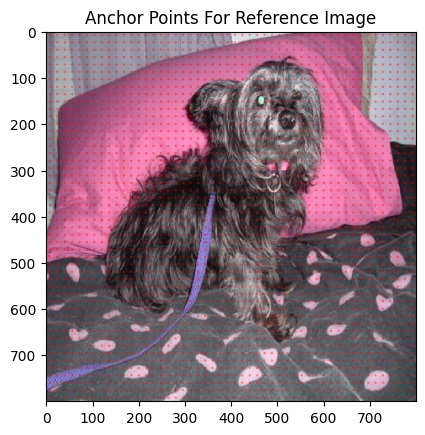

In [23]:
# Viewing Anchor Centers On Reference Image For Debugging
grid_image = display_center_grid(img_pre[0],anchor_centers_image,number_of_anchors)
plt.imshow(display_center_grid(img_pre[0],anchor_centers_image,number_of_anchors))
plt.title("Anchor Points For Reference Image")
plt.savefig("Reference Image Anchor Points")

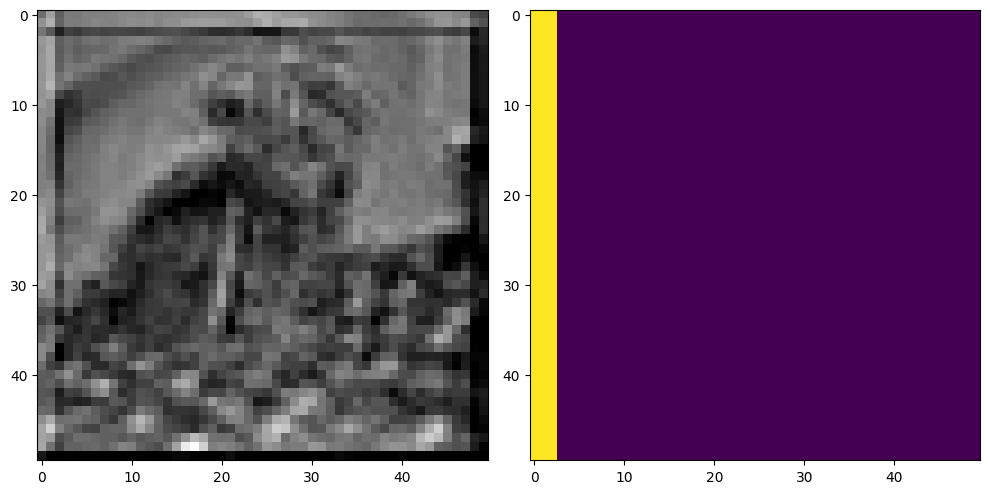

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(feature_map[0,:,:,6], cmap='gray')
ax[1].imshow(display_center_grid(feature_map[0,:,:,6],anchor_centers,50))
plt.tight_layout()
plt.show()

In [25]:
# UTILITY: Creating Anchor Boxes
def create_anchor_boxes(x1, y1, x2, y2, img) -> np.array:
    """
    Creates a grid of the anchor points for the image

    Parameters
    ----------
    x1: X-coordinate of Top Left Corner
    y1: Y-coordinate of Top Left Corner
    x2: X-coordinate of Bottom Right Corner
    y2: Y-coordinate of Bottom Right Corner
    colour: Color for the anchor boxes
    ----------

    Returns
    ----------
    img_box
        Image with anchor box
    ----------
    """
    # Creating Center Coordinate To Isolate Point For Better Understanding
    center_x = (x1+x2) // 2
    center_y = (y1+y2) // 2
    
    # Creating the bounding box centered over a pixel
    img_box = cv.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    img_box = cv.circle(img_box,(center_x,center_y),5,(0,255,0),-1)
    # Image with bounding box
    return img_box

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


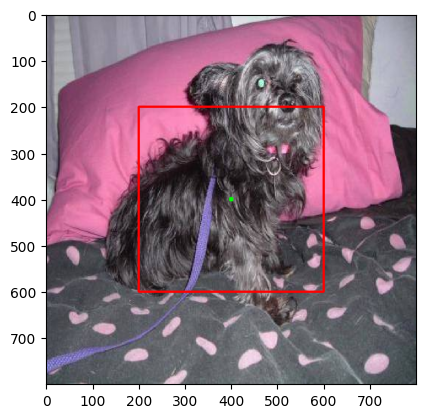

In [26]:
# Testing Anchor Box Creation
plt.imshow(create_anchor_boxes(200,200,600,600,img_pre[0]))

In [27]:
# Creating Different Aspect Anchor Boxes

BASE_ANCHOR_BOX_SIZE = [128,128]
ANCHOR_BOX_RATIOS=[0.5,1,1.5]
ANCHOR_BOX_SCALES = [1,2,3]

def create_aspect_boxes(anchor_box_ratios, anchor_box_scales, base_anchor_box):
    """
    Creates anchor boxes of different ratios and scales

    Parameters
    ----------
    anchor_box_ratio: Different aspect ratios used for the bounding boxes
    anchor_box_scales: Different scale ratios used for the bounding boxes
    base_anchor_box: Base anchor box size
    ----------

    Returns
    ----------
    aspect_box
        List of anchor boxes with different scales and aspect ratios for each anchor point
    ----------
    """

    aspect_box = []
    # Iterate Over the ratios and scales and transform the bounding box dimensions.
    for ratios in anchor_box_ratios:
        for scales in anchor_box_scales:
            if ratios < 1:
                # Taller Box
                width = base_anchor_box[0] * scales * ratios
                height = base_anchor_box[1] * scales
            else:
                # Wider Box
                width = base_anchor_box[0] * scales
                height = base_anchor_box[1] * scales / ratios
            aspect_box.append([width,height])
    return aspect_box

In [28]:
# Created Variable Aspect Ratio Boxes, Not The Absolute Coordinates But The Width & Height Of The Boxes
aspect_ratios_dimensions = create_aspect_boxes(ANCHOR_BOX_RATIOS,ANCHOR_BOX_SCALES,BASE_ANCHOR_BOX_SIZE)
print(f'Aspect Ratio Boxes Size: {aspect_ratios_dimensions}')
print(f'Number Of Aspect Ratio Anchor Boxes: {len(aspect_ratios_dimensions)}')

Aspect Ratio Boxes Size: [[64.0, 128], [128.0, 256], [192.0, 384], [128, 128.0], [256, 256.0], [384, 384.0], [128, 85.33333333333333], [256, 170.66666666666666], [384, 256.0]]
Number Of Aspect Ratio Anchor Boxes: 9


In [29]:
# Creating the Anchor Boxes Relative To The Center Of the Anchor Point
def relative_coordinates(aspect_boxes, x_c, y_c):
    """
    Creates a grid of the anchor points for the image

    Parameters
    ----------
    aspect_boxes: Array of bounding boxes with different aspect ratios and scales
    x_c: X center of the anchor
    y_c: Y center of the anchor
    ----------

    Returns
    ----------
    final_box
        List of anchor boxes for each anchor point
    ----------
    """
    final_box = []
    # Iterate over the transformed boxes and create coordinate relative to the center pixel.
    for boxes in aspect_boxes:
        width_alignment = boxes[0] / 2
        height_alignment = boxes[1] / 2
        final_box.append([x_c - width_alignment, y_c - height_alignment, x_c + width_alignment, y_c + height_alignment])
    # Array of bounding boxes relative to the pixel
    return final_box

In [30]:
# Center Anchor Boxes In The Image
center_anchor_boxes = relative_coordinates(aspect_ratios_dimensions,anchor_centers_image[1250][0],anchor_centers_image[1250][1])
print(f'Center Variable Anchor Boxes:\n {center_anchor_boxes}')
print(f'Number Of Anchor Boxes Per Anchor Center: {len(center_anchor_boxes)}')

Center Variable Anchor Boxes:
 [[376.0, -56.0, 440.0, 72.0], [344.0, -120.0, 472.0, 136.0], [312.0, -184.0, 504.0, 200.0], [344.0, -56.0, 472.0, 72.0], [280.0, -120.0, 536.0, 136.0], [216.0, -184.0, 600.0, 200.0], [344.0, -34.666666666666664, 472.0, 50.666666666666664], [280.0, -77.33333333333333, 536.0, 93.33333333333333], [216.0, -120.0, 600.0, 136.0]]
Number Of Anchor Boxes Per Anchor Center: 9


In [31]:
# Creating function to initialize the anchor boxes for the model
# TODO: Implement To Uniform Shape (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,4)
def initialize_all_anchor_boxes(original_img_shape, feature_map_shape):
    """
    Creates the anchor boxes for feature map that can be used by the model

    Parameters
    ----------
    original_img_shape: Shape of the original image
    feature_map_shape: Shape of the feature map, without the batch dimension
    ----------

    Returns
    ----------
    feature_map_anchor_box_coordinates
        Tensor of anchor boxes for the feature map (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,4)
    ----------
    """
    # Calculate the anchor center strides for the X & Y axes
    anchor_stride_x , anchor_stride_y = calculate_anchor_stride(original_img_shape[1], feature_map_shape[1]) , calculate_anchor_stride(original_img_shape[2], feature_map_shape[2])
    # Calculating the anchor centers for the x and y axes
    anchor_centers = create_anchor_centers(feature_map_shape[1], feature_map_shape[2])
    # Calculating the different aspect ratios and scales for the anchor boxes
    aspect_ratios = tf.constant(create_aspect_boxes(ANCHOR_BOX_RATIOS,ANCHOR_BOX_SCALES,BASE_ANCHOR_BOX_SIZE),dtype=tf.float32)
    # Scaling the anchor box ratios to the feature map size since they are in the original image space for now
    feature_map_aspect_ratios = tf.stack([aspect_ratios[:,0]/anchor_stride_x,aspect_ratios[:,1]/anchor_stride_y],axis=1)
    
    # Calculating the anchor boxes for each center
    # Calculating the X,Y offsets to be added to the center point
    offset_x,offset_y = tf.cast(feature_map_aspect_ratios[:,0]/2,dtype=tf.float32), tf.cast(feature_map_aspect_ratios[:,1]/2,tf.float32)

    # Calculate the values by adding the offsets to the centers separately
    x_centers,y_centers = anchor_centers[:,0] , anchor_centers[:,1]
    # Repeat the tensor so that it is reshaped for the total number of anchor boxes per pixel since the centers for each of the aspect ratio boxes are the same
    x_centers = tf.cast(tf.repeat(x_centers,repeats=tf.shape(feature_map_aspect_ratios)[0]),tf.float32)
    y_centers = tf.cast(tf.repeat(y_centers,repeats=tf.shape(feature_map_aspect_ratios)[0]),tf.float32)

    # Tile the tensor so that the offsets are tiled since the aspect ratios are iterated over
    offset_x,offset_y = tf.tile(offset_x,[tf.shape(anchor_centers)[0]]),tf.tile(offset_y,[tf.shape(anchor_centers)[0]])
    
    # Calculate the four coordinates for the anchor box using the centers
    x_1 = x_centers - offset_x
    x_2 = x_centers + offset_x
    y_1 = y_centers - offset_y
    y_2 = y_centers + offset_y

    # Clipping anchor boxes to stop the the coordinates from going out of bounds
    x_1 = tf.maximum(x_1,0)
    x_2 = tf.minimum(x_2,feature_map_shape[1])
    y_1 = tf.maximum(y_1,0)
    y_2 = tf.minimum(y_2,feature_map_shape[2])
    
    # Stack the coordinates together in format of (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,4)
    feature_map_anchor_box_coordinates = tf.stack([x_1,y_1,x_2,y_2],axis=1)
    feature_map_anchor_box_coordinates = tf.reshape(feature_map_anchor_box_coordinates,[feature_map_shape[1],feature_map_shape[2],-1,4])
    
    # Adding a batch dimension so that it can be tiled
    feature_map_anchor_box_coordinates = tf.expand_dims(feature_map_anchor_box_coordinates,axis=0)
    # Tiling the vector on the batch dimension only, everything else is kept as it is.
    feature_map_anchor_box_coordinates = tf.tile(feature_map_anchor_box_coordinates,[feature_map_shape[0],1,1,1,1])
    
    
    return feature_map_anchor_box_coordinates

In [32]:
initialize_all_anchor_boxes((1,800,800), (1,50,50,512))

<tf.Tensor: shape=(1, 50, 50, 9, 4), dtype=float32, numpy=
array([[[[[ 0.       ,  0.       ,  2.5      ,  4.5      ],
          [ 0.       ,  0.       ,  4.5      ,  8.5      ],
          [ 0.       ,  0.       ,  6.5      , 12.5      ],
          ...,
          [ 0.       ,  0.       ,  4.5      ,  3.1666667],
          [ 0.       ,  0.       ,  8.5      ,  5.8333335],
          [ 0.       ,  0.       , 12.5      ,  8.5      ]],

         [[ 0.       ,  0.       ,  2.5      ,  5.5      ],
          [ 0.       ,  0.       ,  4.5      ,  9.5      ],
          [ 0.       ,  0.       ,  6.5      , 13.5      ],
          ...,
          [ 0.       ,  0.       ,  4.5      ,  4.166667 ],
          [ 0.       ,  0.       ,  8.5      ,  6.8333335],
          [ 0.       ,  0.       , 12.5      ,  9.5      ]],

         [[ 0.       ,  0.       ,  2.5      ,  6.5      ],
          [ 0.       ,  0.       ,  4.5      , 10.5      ],
          [ 0.       ,  0.       ,  6.5      , 14.5      ],
       

In [33]:
# UTILITY: DISPLAY VARIABLE ANCHOR BOXES
def create_relative_anchor_boxes(anchor_boxes, img):
    """
    Creates a grid of the anchor points for the image

    Parameters
    ----------
    image_tensor: Tensor with the image Anchor box
    img: Input Image
    colour: Color of the bounding box
    ----------

    Returns
    ----------
    None
    ----------
    """
    """
    
    """
    for coordinates in anchor_boxes:
            x1 = int(coordinates[0])
            y1 = int(coordinates[1])
            x2 = int(coordinates[2])
            y2 = int(coordinates[3])
            img = create_anchor_boxes(x1, y1, x2, y2, img)
        # Image with multiple bounding boxes over a central pixel
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


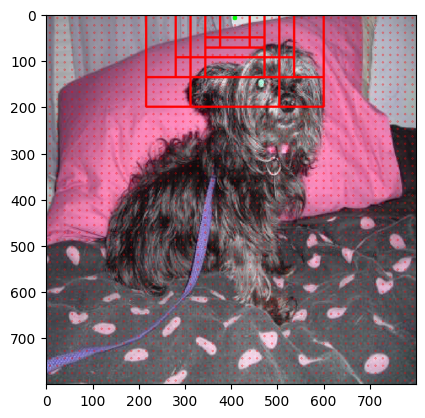

In [34]:
# Displaying Variable Anchor Box On Reference Image
plt.imshow(create_relative_anchor_boxes(center_anchor_boxes,grid_image))

### Use a CNN to predict objectness scores and refine anchor box coordinates.
<ul>
    <li> Predicting Objectness Scores</li>
    <li> Refine Anchor Box Coordinates</li>
</ul>

In [35]:
# Before Finding Objectness Score 3x3 sliding window (according to the paper) needs to be carried out over the feature map.
# This is part of the region proposal network (RPN)
# MODEL: Region Proposal Network Model To Be Used For Modularity In Faster RCNN Model

class RegionProposalNetwork(tf.keras.Model):
    def __init__(self,num_of_anchors_per_pixel,**kwargs):
        """
        Region Proposal Network (RPN) as a subclass of Keras Model.
        
        Parameters:
        ----------
        num_of_anchors_per_pixel : int
            Number of anchor boxes per pixel (depends on the scales and aspect ratios used).
        """
        super(RegionProposalNetwork,self).__init__(**kwargs)

        # Initializing Info About Input Size & Number Of Anchors
        self.num_of_anchors_per_pixel = num_of_anchors_per_pixel
        self.feature_map_height = 50
        self.feature_map_width = 50

        # Creating the convolutional 3x3 layer of the architecture
        self.conv_layer = Conv2D(512,(3,3),padding='same',activation='relu',name="3x3 Conv Layer")

        # Creating Binary Classification Layer To Predict Objects/Background
        self.object_classfication_layer = Conv2D(num_of_anchors_per_pixel * 2,(1,1),activation='softmax',name="Objectness Layer")

        # Creating Bounding Box Regression Layer To Calculate Offsets For Anchor Boxes
        self.bounding_box_regression_layer = Conv2D(num_of_anchors_per_pixel * 4, (1,1),name="Bounding Box Regression Layer")

    def call(self,input_tensor):
        """
        Forward Pass For The Model Using Tensor Flow Model API

        Parameters:
        ---------
        input_tensor : Tensor
            Feature Maps Of Images

        Returns:
        -------
        object_scores: Tensor
            Predicted Scores Of Anchor Boxes Of Either Being Object/Background Made By Model

        offsets: Tensor
            Coordinates For Bounding Boxes Made By Model
        """

        # Need To Pass It Through The 3x3 Conv Layer
        conv_tensor = self.conv_layer(input_tensor)

        # Calculating The Objectness Score & Offset Regression Separately
        object_scores = self.object_classfication_layer(conv_tensor)
        offsets = self.bounding_box_regression_layer(conv_tensor)

        # reshaping the tensors to make into easier format
        object_scores = tf.reshape(object_scores,[object_scores.shape[0],object_scores.shape[1],object_scores.shape[2],self.num_of_anchors_per_pixel,2])
        offsets = tf.reshape(offsets,[offsets.shape[0],offsets.shape[1],offsets.shape[2],self.num_of_anchors_per_pixel,4])

        # We return the scores to the next part
        return object_scores, offsets

    def build_graph(self,input_size):
        """
        Build Graph Method For Examining Layer Architecture

        Parameters:
        ---------
        input_size : Tensor
            Feature Maps Of Images

        Returns:
        -------
           model: Tensorflow Model
               Tensorflow Model Of Region Proposal Network
        """
        x = tf.keras.layers.Input(shape=input_size)

        # Need To Pass It Through The 3x3 Conv Layer
        conv_tensor = self.conv_layer(x)

        # Calculating The Objectness Score & Offset Regression Separately
        object_scores = self.object_classfication_layer(conv_tensor)
        offsets = self.bounding_box_regression_layer(conv_tensor)

        # reshaping the tensors to make into easier format
        object_scores = tf.keras.layers.Reshape((self.feature_map_height, self.feature_map_width, self.num_of_anchors_per_pixel, 2),name="Objectness Score Reshape")(object_scores)
        offsets = tf.keras.layers.Reshape((self.feature_map_height, self.feature_map_width, self.num_of_anchors_per_pixel, 4),name="Bounding Box Offsets Reshape")(offsets)

        return tf.keras.Model(inputs=[x],outputs=[object_scores,offsets])
        

In [36]:
region_proposal_network = RegionProposalNetwork(num_of_anchors_per_pixel=9)

In [37]:
region_proposal_network.build_graph(input_size=(50,50,512)).summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50, 50,    │          0 │ -                 │
│ (InputLayer)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 3x3 Conv Layer      │ (None, 50, 50,    │  2,359,808 │ input_layer_1[0]… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Objectness Layer    │ (None, 50, 50,    │      9,234 │ 3x3 Conv          │
│ (Conv2D)            │ 18)               │            │ Layer[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bounding Box        │ (None, 50, 50,    │     18,468 │ 3x3 Conv          │
│ Regression Layer    │ 36)               │            │ Layer[0][0]       │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Objectness Score    │ (None, 50, 50, 9, │          0 │ Objectness        │
│ Reshape (Reshape)   │ 2)                │            │ Layer[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Bounding Box        │ (None, 50, 50, 9, │          0 │ Bounding Box      │
│ Offsets Reshape     │ 4)                │            │ Regression        │
│ (Reshape)           │                   │            │ Layer[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,387,510 (9.11 MB)

 Trainable params: 2,387,510 (9.11 MB)

 Non-trainable params: 0 (0.00 B)

<p align="center">
    <img src="image_coordinate_axes.png" height="600" width="600">
</p>

In [38]:
# Intersection Over Union Implementation
# Each Ground Truth Box is compared to all the predicted anchor boxes and 
# Now this function calculates the IOU Scores of one ground truth box with all the anchor boxes
# TODO: Implement To Uniform Shape (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,1)
def IOU_scores(ground_truth_boxes,predicted_boxes):
    """
    Calculate IOU Scores For Ground Truth Boxes & All Prediction Boxes

    Parameters:
    ---------
    ground_truth_boxes : Tensor
        Tensor Of Ground Truth Boxes (B,NO_OF_GT_BOXES,4)

    predicted_boxes : Tensor
        Tensor Of Prediction Boxes (B,FEATURE_MAP_WIDTH * FEATURE_MAP_HEIGHT * NUM_OF_ANCHORS_PER_PIXEL,4)    

    Returns:
    -------
    iou_scores: Tensor
        Tensor Of IOU Scores (B,NO_OF_GT_BOXES,NO_OF_PRED_BOXES)
        NOTE: Each row is a ground truth box and each column is a anchor prediction box
    """
    
    # First we need to split up the two boxes into four coordinates each
    x11,y11,x21,y21 = tf.split(ground_truth_boxes,num_or_size_splits=4,axis=-1)
    x12,y12,x22,y22 = tf.split(predicted_boxes,num_or_size_splits=4,axis=-1)

    # print(f'Coordinates Of Box 1: x1:{x11},y1:{y11},x2:{x21},y2:{y21}')
    # print(f'Shapes Of Box 1 Coordinates: x1:{x11.shape},y1:{y11.shape},x2:{x21.shape},y2:{y21.shape}')
    # print(f'Coordinates Of Box 2: x1:{x12},y1:{y12},x2:{x22},y2:{y22}')
    # print(f'Shapes Of Box 2 Coordinates: x1:{x12.shape},y1:{y12.shape},x2:{x22.shape},y2:{y22.shape}')

    x11 = tf.expand_dims(x11,axis=2)
    y11 = tf.expand_dims(y11,axis=2)
    x21 = tf.expand_dims(x21,axis=2)
    y21 = tf.expand_dims(y21,axis=2)

    x12 = tf.expand_dims(x12,axis=1)
    y12 = tf.expand_dims(y12,axis=1)
    x22 = tf.expand_dims(x22,axis=1)
    y22 = tf.expand_dims(y22,axis=1)

    # print(f'X11:{x11} Shape:{x11.shape}')
    # print(f'Y11:{y11} Shape:{y11.shape}')
    # print(f'X21:{x21} Shape:{x21.shape}')
    # print(f'Y21:{y21} Shape:{y21.shape}')
    
    # Now we to get the max and min values for each axes for each top left and bottom right corner of the box
    x1_max = tf.math.maximum(x11,x12)
    y1_max = tf.math.maximum(y11,y12)

    x2_min = tf.math.minimum(x21,x22)
    y2_min = tf.math.minimum(y21,y22)

    # print(f'X1 Max: {x1_max[0]}')
    # print(f'Y1 Max: {y1_max[0]}')
    
    # print(f'X2 Min: {x2_min}')
    # print(f'Y2 Min: {y2_min}')

    # print(f'Top Left Intersection Coordinates {tf.concat([x1_max[0],y1_max[0]],axis=1)}')
    # print(f'Bottom Right Intersection Coordinates {tf.concat([x2_min[0],y2_min[0]],axis=1)}')


    # Now we need to calculate the width and height of the intersection box, we need to stop it from being non-negative as well
    width = tf.math.maximum(0.0,x2_min - x1_max)
    height = tf.math.maximum(0.0,y2_min - y1_max)

    # print(f'Width Of Intersection: {width}')
    # print(f'Height Of Intersection: {height}')

    # Calculate the area of the intersection box for IOU scores
    area_of_intersection = width * height

    # Calculate area of ground truth boxes
    ground_truth_boxes_area = (x21-x11) * (y21-y11)

    # Calculate are of predicted boxes
    predicted_boxes_area = (x22 - x12) * (y22-y12)
    
    # Calculate the are of the union of the two boxes using venn diagram formula
    area_of_union = tf.maximum(0.0,ground_truth_boxes_area + predicted_boxes_area - area_of_intersection)

    # Calculate IOU score using the formula
    iou_scores = area_of_intersection / (area_of_union + 1e-6)

    # print(f'Area of GT Boxes : {ground_truth_boxes_area}')
    # print(f'Area of Pred Boxes: {predicted_boxes_area}')
    # print(f'Area of Intersection: {area_of_intersection}')
    # print(f'Area of Union: {area_of_union}')
    # print(f'IOU Scores: {(iou_scores}')
    
    return tf.squeeze(iou_scores, axis=-1)

    

In [39]:
# UTILITY: Utility Function To Generate Ground Truth Boxes For Testing IOU
def generate_sample_ground_truth_boxes(image_width = 800,image_height = 800,num_gt_boxes = 3):
     # Generate coordinates for the top-left corner
    x1 = tf.random.uniform(shape=(num_gt_boxes,), minval=0, maxval=image_width // 2, dtype=tf.float32)
    y1 = tf.random.uniform(shape=(num_gt_boxes,), minval=0, maxval=image_height // 2, dtype=tf.float32)

    # Generate coordinates for the bottom-right corner
    x2 = tf.clip_by_value(x1 + tf.random.uniform(shape=(num_gt_boxes,), minval=50, maxval=200, dtype=tf.float32), 0, image_width)
    y2 = tf.clip_by_value(y1 + tf.random.uniform(shape=(num_gt_boxes,), minval=50, maxval=200, dtype=tf.float32), 0, image_height)

    # Stack and add batch dimension
    ground_truth_boxes = tf.stack([x1, y1, x2, y2], axis=1)
    return tf.expand_dims(ground_truth_boxes, axis=0)  # Shape (B, NO_OF_GT_BOXES, 4)

In [40]:
tf.concat([
    generate_sample_ground_truth_boxes(image_width = 100, image_height = 100),
    generate_sample_ground_truth_boxes(image_width = 100, image_height = 100)
            ],axis=0)

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[  8.115339,  40.60914 , 100.      , 100.      ],
        [ 26.839983,  19.57504 , 100.      , 100.      ],
        [ 44.77375 ,  34.112965, 100.      , 100.      ]],

       [[ 32.383442,  32.28036 , 100.      ,  98.44493 ],
        [ 10.644901,  28.101843, 100.      , 100.      ],
        [ 20.661032,  47.209156, 100.      , 100.      ]]], dtype=float32)>

In [41]:
def generate_sample_anchor_boxes(image_width = 800, image_height = 800, num_anchor_boxes = 5):
    # Predicted Boxes (top-left (x1, y1), bottom-right (x2, y2))
    # Generating coordinates for the top-left corner
    x1 = tf.random.uniform(shape=(num_anchor_boxes,), minval=0, maxval=image_width // 2, dtype=tf.float32)
    y1 = tf.random.uniform(shape=(num_anchor_boxes,), minval=0, maxval=image_width // 2, dtype=tf.float32)

    # Generating coordinates for the bottom-right corner
    x2 = x1 + tf.random.uniform(shape=(num_anchor_boxes,), minval=50, maxval=200, dtype=tf.float32)
    y2 = y1 + tf.random.uniform(shape=(num_anchor_boxes,), minval=50, maxval=200, dtype=tf.float32)

    # Stacking the coordinates along axis 1 to get shape (num_gt_boxes, 4)
    anchor_boxes = tf.stack([x1, y1, x2, y2], axis=1)
    
    return tf.expand_dims(anchor_boxes,axis=0) # Creating Tensor of Shape (B,NO_OF_PRED_BOXES,BOX_COORDINATES)

In [42]:
# ground_truth_boxes = generate_sample_ground_truth_boxes(image_width = 800, image_height = 800)
ground_truth_boxes = tf.concat([
    generate_sample_ground_truth_boxes(image_width = 800, image_height = 800),
    generate_sample_ground_truth_boxes(image_width = 800, image_height = 800)
            ],axis=0)
predicted_boxes = tf.concat([generate_sample_anchor_boxes(image_width = 800, image_height = 800),generate_sample_anchor_boxes(image_width = 800, image_height = 800)],axis=0)
# predicted_boxes = generate_sample_anchor_boxes(image_width = 800, image_height = 800)
iou_scores = IOU_scores(ground_truth_boxes,predicted_boxes)
iou_scores # Row is a ground truth box, column is the anchor box

<tf.Tensor: shape=(2, 3, 5), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , 0.15663289, 0.02933294],
        [0.        , 0.03673934, 0.        , 0.0624307 , 0.49681363],
        [0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.0039395 , 0.        , 0.        ],
        [0.        , 0.        , 0.24228722, 0.        , 0.21605363],
        [0.        , 0.        , 0.        , 0.        , 0.27428466]]],
      dtype=float32)>

In [43]:
# UTILITY: Utility Function To Check IOU intersection
def plot_bounding_boxes(ground_truth_boxes, predicted_boxes, size=100):
    # Ensure size is within the desired range
    size = min(max(size, 100), 800)  # Constrain to between 100 and 800
    figure_scale = size / 100  
    fig_width, fig_height = 8 * figure_scale, 8 * figure_scale
    
    for batch in range(ground_truth_boxes.shape[0]):
        # Split ground truth boxes into four coordinates
        gt_x1, gt_y1, gt_x2, gt_y2 = tf.split(ground_truth_boxes[batch, :, :], num_or_size_splits=4, axis=-1)
        
        # Split predicted boxes into four coordinates
        pred_x1, pred_y1, pred_x2, pred_y2 = tf.split(predicted_boxes[batch, :, :], num_or_size_splits=4, axis=-1)
        
        iou_scores = IOU_scores(ground_truth_boxes, predicted_boxes)[batch, :, :]
        
        fig, axs = plt.subplots(ground_truth_boxes.shape[1], figsize=(fig_width, fig_height))
        
        for box_index in range(ground_truth_boxes.shape[1]):
            gt_bottom_left_x = gt_x1[box_index].numpy()
            gt_bottom_left_y = gt_y2[box_index].numpy()
            gt_width = gt_x2[box_index].numpy() - gt_x1[box_index].numpy()
            gt_height = gt_y1[box_index].numpy() - gt_y2[box_index].numpy()
            
            axs[box_index].add_patch(plt.Rectangle(
                (gt_bottom_left_x, gt_bottom_left_y),
                gt_width,
                gt_height,
                edgecolor='green',
                facecolor='none',
                linewidth=2,
                label='Ground Truth'
            ))
            
            axs[box_index].set_xlim([0, size])
            axs[box_index].set_ylim([0, size])
            axs[box_index].invert_yaxis()  # Optional: to match standard image coordinates
            axs[box_index].set_title(f'Ground Truth Box {box_index + 1}')
            axs[box_index].set_aspect('equal', adjustable='box')
            
            for pred_index in range(predicted_boxes.shape[1]):
                pred_bottom_left_x = pred_x1[pred_index].numpy()
                pred_bottom_left_y = pred_y2[pred_index].numpy()
                pred_width = pred_x2[pred_index].numpy() - pred_x1[pred_index].numpy()
                pred_height = pred_y1[pred_index].numpy() - pred_y2[pred_index].numpy()
                
                axs[box_index].add_patch(plt.Rectangle(
                    (pred_bottom_left_x, pred_bottom_left_y),
                    pred_width,
                    pred_height,
                    edgecolor='orange',
                    facecolor='none',
                    linewidth=1,
                    linestyle='--',
                    label='Predicted'
                ))
                
                axs[box_index].text(pred_x1[pred_index].numpy(), pred_y1[pred_index].numpy(),
                                    f'IOU: {iou_scores[box_index, pred_index]:.2f}',
                                    verticalalignment='bottom')
                
            axs[box_index].legend(['Ground Truth', 'Predicted'], loc='upper right')
        
        # plt.tight_layout()
        plt.show()

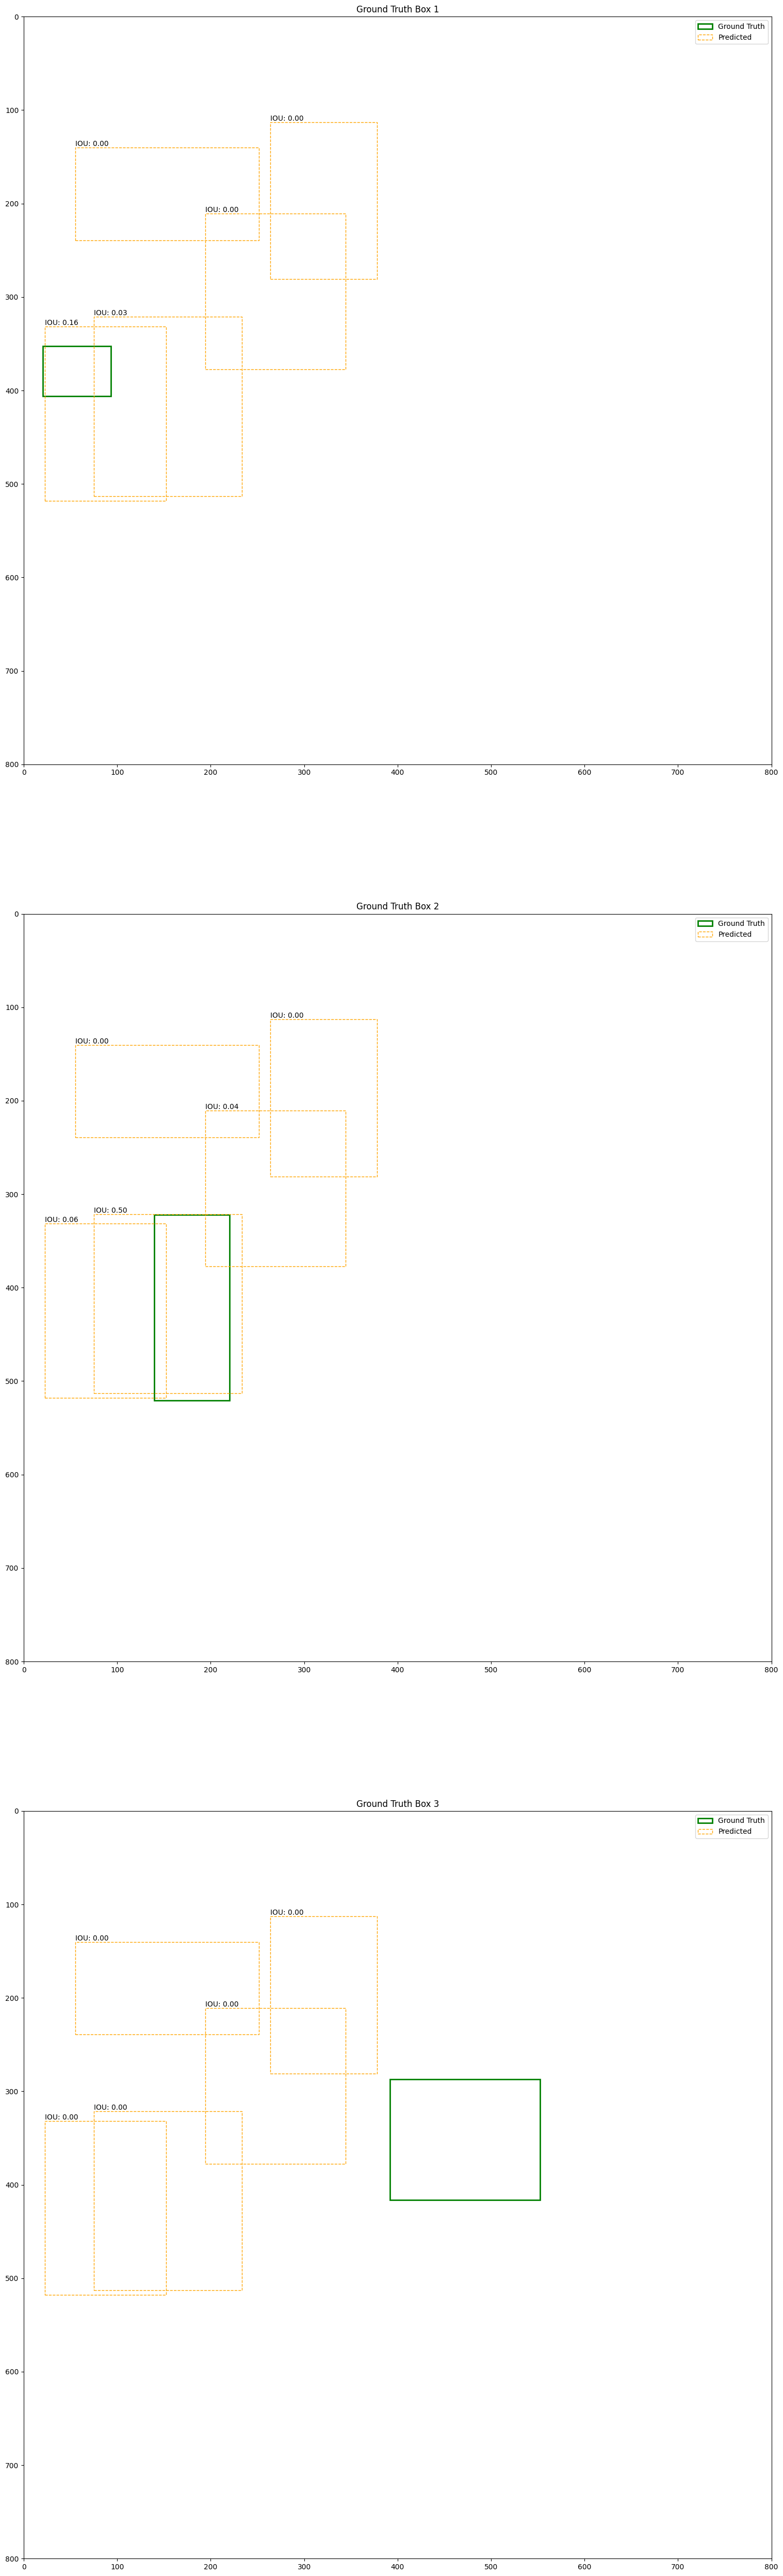

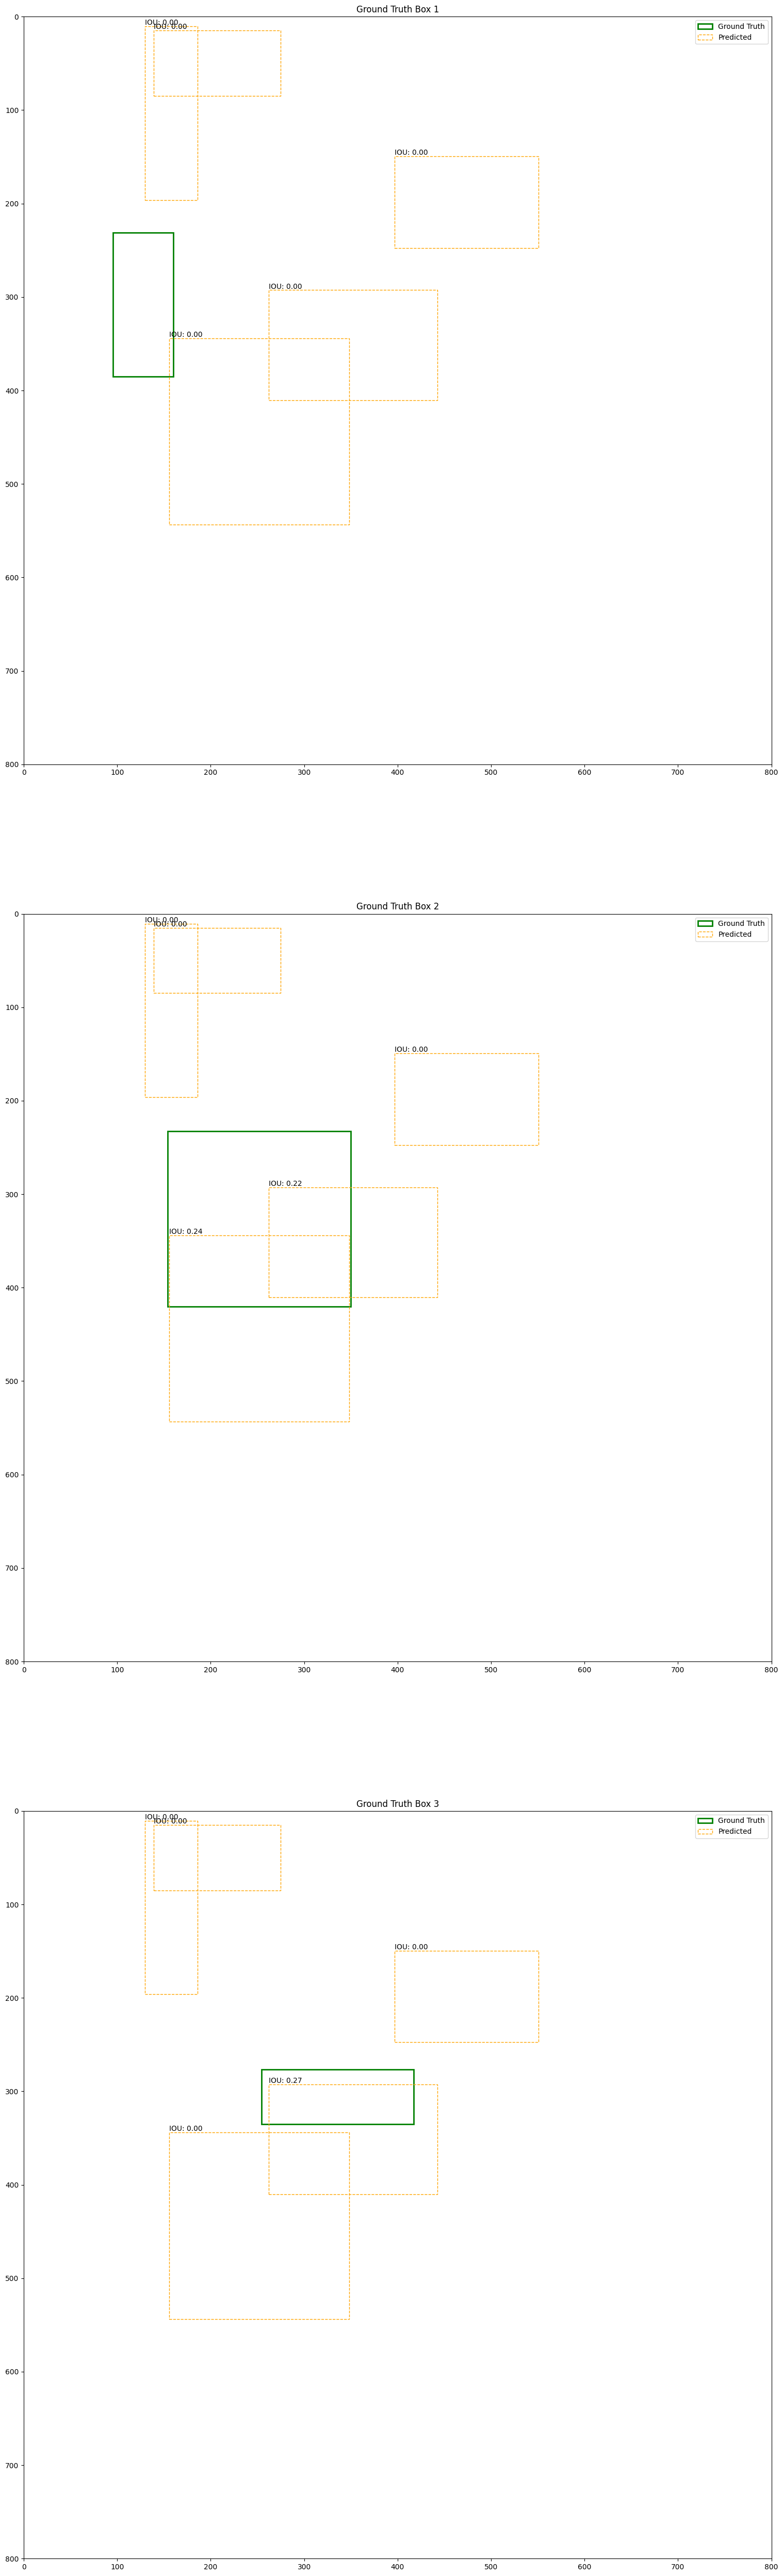

In [44]:

# ground_truth_boxes = tf.constant([
#     [1, 2, 3, 4],   # Box 1
#     [2, 3, 4, 5],   # Box 2
#     [4, 1, 5, 4]    # Box 3
# ], dtype=tf.float32)

# predicted_boxes = tf.constant([
#     [1, 1, 3, 3],  # Box 1
#     [0, 0, 6, 6],  # Box 2
#     [4, 2, 5, 5],  # Box 3
#     [1, 2, 3, 4]
# ], dtype=tf.float32)

# ground_truth_boxes = generate_sample_ground_truth_boxes(image_width = 800, image_height = 800)
# predicted_boxes = generate_sample_anchor_boxes(image_width = 800, image_height = 800)

plot_bounding_boxes(ground_truth_boxes,predicted_boxes,size=800)

In [45]:
# Checking if the initialized anchor boxes can be used in the IOU scoring function
anchor_boxes = initialize_all_anchor_boxes((2,800,800), (2,50,50,512))

In [46]:
anchor_boxes[:,25,25,:,:]

<tf.Tensor: shape=(2, 9, 4), dtype=float32, numpy=
array([[[23.5     , 21.5     , 27.5     , 29.5     ],
        [21.5     , 17.5     , 29.5     , 33.5     ],
        [19.5     , 13.5     , 31.5     , 37.5     ],
        [21.5     , 21.5     , 29.5     , 29.5     ],
        [17.5     , 17.5     , 33.5     , 33.5     ],
        [13.5     , 13.5     , 37.5     , 37.5     ],
        [21.5     , 22.833334, 29.5     , 28.166666],
        [17.5     , 20.166666, 33.5     , 30.833334],
        [13.5     , 17.5     , 37.5     , 33.5     ]],

       [[23.5     , 21.5     , 27.5     , 29.5     ],
        [21.5     , 17.5     , 29.5     , 33.5     ],
        [19.5     , 13.5     , 31.5     , 37.5     ],
        [21.5     , 21.5     , 29.5     , 29.5     ],
        [17.5     , 17.5     , 33.5     , 33.5     ],
        [13.5     , 13.5     , 37.5     , 37.5     ],
        [21.5     , 22.833334, 29.5     , 28.166666],
        [17.5     , 20.166666, 33.5     , 30.833334],
        [13.5     , 17.5     

In [47]:
anchor_centers[1275]

array([25.5, 25.5])

In [48]:
# UTILITY: Utility function to display anchor box around a center coordinate
import matplotlib.colors as mcolors
import random

def display_anchor_box_around_center_coordinate(anchor_boxes,center_x,center_y,plot_width = 50,plot_height = 50):
    batch_size,num_of_anchors,_ = anchor_boxes.shape
    colors = ['red','chartreuse','turquoise','deepskyblue','midnightblue','darkslateblue','darkviolet','deeppink','darkorange']
    for batch_index in range(batch_size):
        fig, axs = plt.subplots(anchor_boxes.shape[0], figsize=(plot_width, plot_height)) # We create spearate image for each batch and overlay all the anchor boxes on top of each other
        for box_index in range(anchor_boxes.shape[1]):
            # Iterate through the anchor boxes and then plot them
            anchor_box = anchor_boxes[batch_index,box_index,:]
            x1,y1,x2,y2 = tf.split(anchor_box,num_or_size_splits=4,axis=-1)
            width = x2 - x1
            height = y2 - y1
            
            axs.add_patch(plt.Rectangle(
                (x1, y1),
                width,
                height,
                edgecolor=colors[box_index],
                facecolor='none',
                linewidth=2,
                linestyle='--',
                label='Ground Truth'
            ))

            axs.plot(center_x, center_y, 'ro', label='Center Point')
            axs.plot(x1,y1,'bo',label="LB")
            axs.plot(x1 + width,y1 + height,'yo',label="RB")
            axs.set_xlim([0, plot_width])
            axs.set_ylim([0, plot_height])
            axs.invert_yaxis()
            axs.set_title(f'Ground Truth Box {box_index + 1}')
            axs.set_aspect('equal', adjustable='box')

In [49]:
# display_anchor_box_around_center_coordinate(anchor_boxes[:,25,25,:,:],anchor_centers[1275][0],anchor_centers[1275][1])

In [50]:
objectness_score,offsets = region_proposal_network.call(feature_map)

In [51]:
# The model predicts offsets so the anchor boxes need to be converted from (x1,y1,x2,y2) format to (xc,yc,w,h) for refinement
# Creating a function to convert the formats of the anchor boxes
def convert_bounding_box_format(anchor_boxes):
    """
    Calculate the anchor box format from (x1,y1,x2,y2) to (xc,yc,w,h) so that the refinements can be calculated

    Parameters:
    ---------
    anchor_boxes : Tensor
        Tensor Of anchor boxes (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,4)

    Returns:
    -------
    converted_boxes: Tensor
        Tensor Of Anchor boxes (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,4)
        NOTE: Used for anchor box offset refinements only
    """
    # Split the coordinates into their individual points for both the axes
    x1,y1,x2,y2 = tf.split(anchor_boxes,num_or_size_splits=4,axis=-1)

    # There is an issue where splitting creates a new dimension in the tensor making the shape 
    # from (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS) to (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS,1)
    x1 = tf.squeeze(x1,axis=-1)
    x2 = tf.squeeze(x2,axis=-1)
    y1 = tf.squeeze(y1,axis=-1)
    y2 = tf.squeeze(y2,axis=-1)

    # Calculating the centers and the width and height of the boxes
    xc = (x2+x1) / 2.0
    yc = (y2+y1) / 2.0
    w = (x2 - x1)
    h = (y2 - y1)

    # Stacking the boxes after squeezing makes the shape to be (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS,4)
    # instead of (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS,1,4)
    converted_boxes = tf.stack([xc,yc,w,h],axis=-1)

    return converted_boxes
    

In [52]:
 convert_bounding_box_format(ground_truth_boxes)

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[ 56.73776 , 379.2995  ,  72.74676 ,  53.860016],
        [179.9307  , 421.44217 ,  80.77821 , 198.43451 ],
        [472.29233 , 351.69748 , 160.71136 , 129.00018 ]],

       [[127.76123 , 308.3393  ,  64.88648 , 154.02611 ],
        [251.8587  , 326.3058  , 195.51723 , 187.8653  ],
        [336.0428  , 306.051   , 162.81012 ,  58.47882 ]]], dtype=float32)>

In [53]:
ground_truth_boxes

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[ 20.36438 , 352.3695  ,  93.11114 , 406.22952 ],
        [139.54158 , 322.2249  , 220.3198  , 520.6594  ],
        [391.93665 , 287.1974  , 552.648   , 416.19757 ]],

       [[ 95.317986, 231.32625 , 160.20447 , 385.35236 ],
        [154.10008 , 232.37314 , 349.6173  , 420.23843 ],
        [254.63773 , 276.81158 , 417.44785 , 335.2904  ]]], dtype=float32)>

In [54]:
# IOU Thresholds For Determining If Object Is Positive (Foreground) or Negative (Background)
IOU_FOREGROUND_THRESH = 0.7 # Used In The Paper
IOU_BACKGROUND_THRESH = 0.4

In [55]:
# Assigning Positive Or Negative Labels
# For Each Ground Truth Box & Predicted Box Combo Assign A Label
def assign_object_label(iou_scores_tensor,IOU_FOREGROUND_THRESH = 0.7,IOU_BACKGROUND_THRESH = 0.4,FEATURE_MAP_WIDTH= 50,FEATURE_MAP_HEIGHT= 50,NUM_OF_ANCHORS_PER_PIXEL= 9):
    """
    Assign Object Labels If They Are Foreground (Object) or Background

    Parameters:
    ---------
    iou_scores_tensor : Tensor
        Tensor Of IOU Scores Shape (B,GT_BOXES,PRED_BOXES)

    Returns:
    -------
    object_label_tensor: Tensor
        Tensor Of Object Labels (B, FEATURE_MAP_WIDTH, FEATURE_MAP_HEIGHT, NUM_OF_ANCHORS_PER_PIXEL, 1)
    """
    
    # Need to implement the rule where max IOU per anchor box is considered
    max_iou_per_anchor_box = tf.reduce_max(iou_scores_tensor,axis=1)
    
    # Everything is considered a background. So it does not need to check for negative labels.
    object_label_tensor = tf.zeros_like(max_iou_per_anchor_box,dtype=tf.int64)

    # Calculate Positive Labels -> Ignored Labels
    object_label_tensor = tf.where(max_iou_per_anchor_box >IOU_FOREGROUND_THRESH,1,object_label_tensor)
    object_label_tensor = tf.where((max_iou_per_anchor_box <= IOU_FOREGROUND_THRESH) & (max_iou_per_anchor_box >= IOU_BACKGROUND_THRESH),-1,object_label_tensor)

    # Need to consider a proposal for each anchor box so the max per ground truth box
    max_iou_indices_per_gt_box = tf.argmax(iou_scores_tensor,axis=-1) # Looks at the anchors in the last axis
    batch_range = tf.range(max_iou_indices_per_gt_box.shape[0],dtype=tf.int64) # Create a range for that can be repeated for the max IOU per GT Box
    batch_rank = tf.repeat(batch_range,[max_iou_indices_per_gt_box.shape[1]]) # Each image will have fixed NUM_GT_BOXES
    flattened_max_iou_indices = tf.reshape(max_iou_indices_per_gt_box,[-1]) # Flattened the indices to make it easier for stacking
    stacked_ranks = tf.stack([batch_rank,flattened_max_iou_indices],axis=-1) # Stacked the ranks to make it easier to update the main index
    object_label_tensor = tf.tensor_scatter_nd_update(object_label_tensor,stacked_ranks,tf.ones_like(flattened_max_iou_indices))
    
    # Reshaping the objectness labels to the shape (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,1)
    object_label_tensor = tf.reshape(object_label_tensor,(iou_scores_tensor.shape[0],FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,1))

    return object_label_tensor

In [56]:
# tf.concat([
#     generate_sample_ground_truth_boxes(image_width = 800, image_height = 800),
#     generate_sample_ground_truth_boxes(image_width = 800, image_height = 800)
#             ],axis=0)
iou_scores = IOU_scores(ground_truth_boxes,tf.reshape(anchor_boxes * 16,[anchor_boxes.shape[0],anchor_boxes.shape[1]*anchor_boxes.shape[2]*anchor_boxes.shape[3],4]))

In [57]:
iou_scores

<tf.Tensor: shape=(2, 3, 22500), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [58]:
# tf.argmax(iou_scores,axis=2)
print(iou_scores[0,0,3393])
print(iou_scores[0,1,3690])
print(iou_scores[0,2,1062])

tf.Tensor(0.012923383, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [59]:
object_labels = assign_object_label(iou_scores)
# tf.gather(object_labels,[ 0, 14, 22,  3,  0])
tf.where(object_labels == 1)

<tf.Tensor: shape=(14, 5), dtype=int64, numpy=
array([[ 0,  1, 23,  6,  0],
       [ 0, 11, 24,  0,  0],
       [ 0, 28, 21,  3,  0],
       [ 0, 28, 22,  3,  0],
       [ 0, 29, 21,  3,  0],
       [ 0, 29, 22,  3,  0],
       [ 0, 30, 21,  3,  0],
       [ 0, 30, 22,  3,  0],
       [ 1,  7, 18,  0,  0],
       [ 1, 14, 20,  7,  0],
       [ 1, 15, 20,  7,  0],
       [ 1, 16, 20,  7,  0],
       [ 1, 17, 20,  7,  0],
       [ 1, 20, 19,  6,  0]])>

In [60]:
feature_map.shape

TensorShape([2, 50, 50, 512])

In [61]:
objectness_score.shape

TensorShape([2, 50, 50, 9, 2])

In [62]:
# offsets

In [63]:
# Function that will generate the objectness labels (0-background,1-foreground,-1-Ignore) for the anchor boxes on the feature map
def generate_objectness_labels(anchor_boxes,gt_boxes,anchor_stride_x = 16,anchor_stride_y = 16):
    """
    Generate objectness labels for the anchor boxes in the feature map
     0 - Background
     1 - Object/Foreground
    -1 - Ignore Object

    Parameters:
    ---------
    anchor_boxes : Tensor
        Tensor of anchor boxes for the feature map (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,4)
    
    gt_boxes : Tensor
        Tensor Of Ground Truth Boxes (B,NO_OF_GT_BOXES,4)

    Returns:
    -------
    object_labels : Tensor
        Tensor of object labels based on the IOU Thresholds (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,1)
    iou_matrix : Tensor
        Tensor of IOU scores that are calculated for the ground truth boxes and the anchor boxes (B,GT_BOXES,NUM_TOTAL_ANCHORS)
    """
    batch_size , feature_map_width, feature_map_height , num_of_anchors_per_pixel = anchor_boxes.shape[0],anchor_boxes.shape[1],anchor_boxes.shape[2],anchor_boxes.shape[3]

    # Get IOU Matrix For the anchor boxes
    # Need to scale the anchor boxes from the feature space to the image space.
    anchor_boxes = anchor_boxes * anchor_stride_x
    # Flattened the anchor boxes to [B,FEATURE_MAP_WIDTH * FEATURE_MAP_HEIGHT * NUM_OF_ANCHORS_PER_PIXEL,4]
    anchor_boxes =  tf.reshape(anchor_boxes,[anchor_boxes.shape[0],anchor_boxes.shape[1]*anchor_boxes.shape[2]*anchor_boxes.shape[3],4])
    
    iou_matrix = IOU_scores(gt_boxes,anchor_boxes) # IOU matrix for the anchor boxes and the ground truth boxes
    # Reshaping the IOU matrix to be in the shape of the original anchor boxes
    # iou_matrix = tf.reshape(iou_matrix,[batch_size,feature_map_width,feature_map_height,1])

    # Assigning labels for the IOU matrix based on the thresholding
    object_labels = assign_object_label(iou_matrix)

    return object_labels,iou_matrix

In [64]:
object_labels,iou_matrix = generate_objectness_labels(anchor_boxes,ground_truth_boxes)

In [65]:
iou_matrix

<tf.Tensor: shape=(2, 3, 22500), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [66]:
tf.where(object_labels == 1)

<tf.Tensor: shape=(14, 5), dtype=int64, numpy=
array([[ 0,  1, 23,  6,  0],
       [ 0, 11, 24,  0,  0],
       [ 0, 28, 21,  3,  0],
       [ 0, 28, 22,  3,  0],
       [ 0, 29, 21,  3,  0],
       [ 0, 29, 22,  3,  0],
       [ 0, 30, 21,  3,  0],
       [ 0, 30, 22,  3,  0],
       [ 1,  7, 18,  0,  0],
       [ 1, 14, 20,  7,  0],
       [ 1, 15, 20,  7,  0],
       [ 1, 16, 20,  7,  0],
       [ 1, 17, 20,  7,  0],
       [ 1, 20, 19,  6,  0]])>

In [91]:
# object_labels
tf.where(tf.squeeze(object_labels,axis=-1) == 1)

<tf.Tensor: shape=(14, 4), dtype=int64, numpy=
array([[ 0,  1, 23,  6],
       [ 0, 11, 24,  0],
       [ 0, 28, 21,  3],
       [ 0, 28, 22,  3],
       [ 0, 29, 21,  3],
       [ 0, 29, 22,  3],
       [ 0, 30, 21,  3],
       [ 0, 30, 22,  3],
       [ 1,  7, 18,  0],
       [ 1, 14, 20,  7],
       [ 1, 15, 20,  7],
       [ 1, 16, 20,  7],
       [ 1, 17, 20,  7],
       [ 1, 20, 19,  6]])>

### Compute RPN loss (classification and regression).
<ul>
    <li>Calculate the Classification (Objectness) Loss</li>
    <li>Calculate the Bounding Box Regression Loss</li>    
</ul>

In [113]:
# Creating a function for getting the positive anchor boxes
def get_positive_anchor_boxes_and_corresponding_offsets(anchor_boxes,offsets,object_labels):
    """
    Get the positive anchor boxes based on their object labels

    Parameters:
    ---------
    anchor_boxes : Tensor
        Tensor of the anchor boxes in the shape (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,4)

    offsets : Tensor
        Tensor of the offsets in the shape (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,4)
        
    object_labels: Tensor
        Tensor of the object labels

    Returns:
    -------
    positive_anchor_boxes:
        Positive anchor boxes in the shape of (NUM_POS_ANCHORS,4)
    """
    # Creating the positive mask and then getting the indices
    # We need to gather the bounding boxes
    positive_mask = tf.squeeze(object_labels,axis=-1) == 1 # Squeezing the last axis from the object labels
    positive_indices = tf.where(positive_mask) 
    positive_anchor_boxes = tf.gather_nd(anchor_boxes,positive_indices)

    # Using the same indices to get the offsets for the anchor_boxes
    offsets_for_positive_anchor_boxes = tf.gather_nd(offsets,positive_indices)

    return positive_anchor_boxes, offsets_for_positive_anchor_boxes,positive_indices

In [114]:
positive_anchor_boxes, offsets_for_positive_anchor_boxes,positive_indices = get_positive_anchor_boxes_and_corresponding_offsets(anchor_boxes,offsets,object_labels)

In [69]:
# Implementing the function for Binary log loss between the object labels and the predicted values
def calculate_objectness_loss(predicted_scores,target_object_labels):
    """
    Calculate the binary cross entropy loss for the model between the objectness predicted score from the RPN and the target labels based on the IOU matrix

    Parameters:
    ---------
    predicted_scores : Tensor
        Tensor of the foreground scores of the predicted scores in the shape (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,1)
        
    target_object_labels: Tensor
        Tensor of the target object labels which are obtained from the IOU matrix and the IOU Threshold rules

    Returns:
    -------
    objectness_loss:
        Binary Cross Entropy Loss for the objectness model scores
    """

    # We have the object (1), background (0) and ignored labels (-1).
    # We have to mask the values in the tensor so that unnecessary information is not taken into account.
    # boolean_mask_matrix = target_object_labels != -1
    # mask = tf.cast(boolean_mask_matrix,dtype=tf.int32)
    # retained_labels = target_object_labels * mask
    retained_labels = tf.where(target_object_labels == -1, tf.zeros_like(target_object_labels), target_object_labels)
    binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()
    objectness_loss = binary_cross_entropy(retained_labels,predicted_scores)

    return objectness_loss

In [70]:
calculate_objectness_loss(objectness_score[...,1],object_labels)

<tf.Tensor: shape=(), dtype=float32, numpy=0.05804087>

In [71]:
# Calculating the bounding box deltas for the predicted boxes, anchor boxes, ground truth boxes
def calculate_bounding_box_deltas_between_pred_and_anchor_box(anchor_boxes,pred_boxes):
    """
    Calculate the bounding box deltas 't' between the predicted anchor box offsets and the anchor boxes generated

    Parameters:
    ---------
    anchor_boxes : Tensor
        Tensor Of Generated Anchor Boxes (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS,4)

    pred_boxes : Tensor
        Tensor Of Predicted Anchor Box Offsets By RPN (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS,4)
    Returns:
    -------
    t: Tensor
        Bounding Box offsets between the predicted RPN anchor boxes and the predefined anchor boxes (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS,4)       
    """
    # Splitting the anchor boxes into xc,yc,w,h separately
    anc_xc,anc_yc,anc_w,anc_h = tf.split(anchor_boxes,num_or_size_splits = 4,axis=-1)

    # Splitting the predicted boxes into xc,yc,w,h separately
    pred_xc,pred_yc,pred_w,pred_h = tf.split(pred_boxes,num_or_size_splits = 4,axis=-1)

    # According to the paper the deltas, the coefficients are calculated for the anchor box as well as
    # ground truth box called t & t*. These are only for positive anchors only
    tx = (pred_xc - anc_xc) / (anc_w + 1e-6)
    ty = (pred_yc - anc_yc) / (anc_h + 1e-6)
    tw = tf.math.log(tf.maximum((pred_w/(anc_w + 1e-6)),1e-6)) # Adding an epsilon value to prevent a NaN being made from division by zero
    th = tf.math.log(tf.maximum((pred_h/(anc_h + 1e-6)),1e-6))

    # Squeezing the last dimension
    tx = tf.squeeze(tx,axis=-1)
    ty = tf.squeeze(ty,axis=-1)
    tw = tf.squeeze(tw,axis=-1)
    th = tf.squeeze(th,axis=-1)
    
    t = tf.stack([tx,ty,tw,th],axis=-1)
    
    return t

In [72]:
# Calculating the bounding box deltas for the anchor boxes, ground truth boxes
def calculate_bounding_box_deltas_between_gt_boxes(gt_boxes,anchor_boxes,iou_matrix,object_labels):
    """
    Calculate the bounding box deltas 't*' between the ground truth boxes and their corresponding anchor boxes
    
    Parameters:
    ---------
    gt_boxes : Tensor
        Tensor Of Generated Anchor Boxes (B,GT_BOXES,4)

    anchor_boxes : Tensor
        Tensor Of Predicted Anchor Box Offsets By RPN (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS,4)

    iou_matrix : Tensor
        Tensor of IOU Matrix for the anchor boxes (B,GT_BOXES,NUM_TOTAL_ANCHORS)

    object_labels : Tensor
        Tensor Of Object Labels (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_ANCHORS,1)
        
    Returns:
    -------
    t: Tensor
        Bounding Box offsets between the ground truth boxes and the predefined anchor boxes (NUM_POS_ANCHORS,4)
    """

    batch_size , feature_map_width, feature_map_height,number_of_anchors_per_pixel , _ = anchor_boxes.shape
    object_labels = tf.reshape(tf.squeeze(object_labels,axis=-1),[object_labels.shape[0],object_labels.shape[1]*object_labels.shape[2]*object_labels.shape[3],1])
    anchor_boxes = tf.reshape(anchor_boxes,[anchor_boxes.shape[0],anchor_boxes.shape[1]*anchor_boxes.shape[2]*anchor_boxes.shape[3],4])

    # We need to gather the bounding boxes
    positive_mask = tf.squeeze(object_labels,axis=-1) == 1
    positive_indices = tf.where(positive_mask)
    positive_anchor_boxes = tf.gather_nd(anchor_boxes,positive_indices)

    # Now we need to gather the ground truth box which these positive anchors are associated with
    gt_box_per_anchor_box_indices = tf.argmax(iou_matrix,axis=1)
    positive_gt_indices = tf.boolean_mask(gt_box_per_anchor_box_indices,positive_mask)
    batch_indices = positive_indices[:, 0]
    batch_and_gt_indices = tf.stack([batch_indices, positive_gt_indices], axis=-1)
    corresponding_gt_boxes = tf.gather_nd(gt_boxes,batch_and_gt_indices)

    corresponding_gt_boxes = convert_bounding_box_format(corresponding_gt_boxes)
    positive_anchor_boxes = convert_bounding_box_format(positive_anchor_boxes)

    # Splitting the anchor boxes into xc,yc,w,h separately
    gt_xc,gt_yc,gt_w,gt_h = tf.split(corresponding_gt_boxes,num_or_size_splits = 4,axis=-1)

    # Splitting the predicted boxes into xc,yc,w,h separately
    pred_xc,pred_yc,pred_w,pred_h = tf.split(positive_anchor_boxes,num_or_size_splits = 4,axis=-1)

    # According to the paper the deltas, the coefficients are calculated for the anchor box as well as
    # ground truth box called t & t*. These are only for positive anchors only
    tx = (pred_xc - gt_xc) / (gt_w + 1e-6)
    ty = (pred_yc - gt_yc) / (gt_h + 1e-6)
    tw = tf.math.log(tf.maximum((pred_w/(gt_w + 1e-6)),1e-6))
    th = tf.math.log(tf.maximum((pred_h/(gt_h + 1e-6)),1e-6))

    # Squeezing the last dimension
    tx = tf.squeeze(tx,axis=-1)
    ty = tf.squeeze(ty,axis=-1)
    tw = tf.squeeze(tw,axis=-1)
    th = tf.squeeze(th,axis=-1)
    
    t = tf.stack([tx,ty,tw,th],axis=-1)

    return t


In [73]:
formatted_anchor_boxes = convert_bounding_box_format(anchor_boxes * anchor_stride_x)
formatted_gt_boxes = convert_bounding_box_format(ground_truth_boxes)

In [74]:
t = calculate_bounding_box_deltas_between_pred_and_anchor_box(formatted_anchor_boxes,offsets)

In [75]:
# t

In [76]:
calculate_bounding_box_deltas_between_gt_boxes(formatted_gt_boxes,formatted_anchor_boxes,iou_matrix,object_labels)

<tf.Tensor: shape=(14, 4), dtype=float32, numpy=
array([[  0.07856479,  -0.04328577,   1.0110385 ,  -0.11299931],
       [  0.06408777,   0.22393112,   0.19083288,   0.16874298],
       [  0.07863712,   0.01952799,   0.05135437,  -0.03053501],
       [  0.07863712,  -0.01639521,   0.05135437,   0.04092392],
       [  0.05296161,   0.01952799,   0.09898247,  -0.03053501],
       [  0.05296161,  -0.01639521,   0.09898247,   0.04092392],
       [  0.0272861 ,   0.01952799,   0.14444478,  -0.03053501],
       [  0.0272861 ,  -0.01639521,   0.14444478,   0.04092392],
       [  0.0687693 ,   0.12431024,  -0.11579293,   0.08497978],
       [ -0.3605167 ,   0.0559966 , -13.815511  ,   0.12792599],
       [ -0.502508  ,   0.0559966 , -13.815511  ,   0.12792599],
       [ -0.6444993 ,   0.0559966 ,  -1.9519895 ,   0.12792599],
       [ -0.7864906 ,   0.0559966 ,  -0.85337716,   0.12792599],
       [  0.12368599,  -0.06625037,   0.14368181,  -0.08822159]],
      dtype=float32)>

In [77]:
# Calculating the smooth L1 loss that happens between the offsets t and t*
def smooth_l1_loss(prediction,ground_truth,beta = 1.0):
    """
    Calculates the Smooth L1 loss based on the formula
    
    Parameters:
    ---------
    prediction: Tensor
        Tensor of the predicted values

    ground_truth: Tensor
        Tensor of the ground truth values

    beta: Float
        Value for the loss thresholding to apply the appropriate loss calculation on the value

    Returns:
    -------
    loss: Float
        L1 loss value for the tensors
    """
    abs_loss = tf.math.abs(prediction - ground_truth)
    # Loss is calculated depending on if the absolute loss is less than beta value
    loss = tf.math.reduce_mean(tf.where(abs_loss < beta,((abs_loss ** 2)/2),((abs_loss - beta)/2))) # Mean since the formula uses MAE formula
    
    return loss

In [78]:
# Calculating the bounding box regression loss (L_reg) for the bounding box offsets of the model and the anchor boxes
def calculate_bounding_box_regression_loss(anchor_boxes,offsets,gt_boxes,iou_matrix,object_labels,anchor_scaling_stride = 16):
    """
    Calculates the bounding box regression loss for the offsets
    
    Parameters:
    ---------
    anchor_boxes: Tensor
        Tensor of the anchor boxes (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_ANCHORS,4)

    offsets: Tensor
        Tensor of the predicted offsets (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_ANCHORS,4)

    gt_boxes: Tensor
        Tensor of the ground truth boxes (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_ANCHORS,4)

    iou_matrix: Tensor
        Tensor of the IoU values for the anchor boxes (B,GT_BOXES,NUM_TOTAL_ANCHORS)

    object_labels: Tensor
        Tensor of the object classes (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,1)

    anchor_scaling_stride: Float
        Value for scaling the anchor boxes from the feature map space to the image space

    Returns:
    -------
    loss: Float
        L1 loss value for the offsets t and t*
    """
    # First the bounding boxes need to be converted from [x1,y1,x2,y2] format to [xc,yc,w,h]
    formatted_anchor_boxes = convert_bounding_box_format(anchor_boxes * anchor_scaling_stride) # Converted anchor boxes into format [xc,yc,w,h]
    formatted_gt_boxes = convert_bounding_box_format(gt_boxes) # Converted ground truth boxes into format [xc,yc,w,h]

    # After conversion the offsets t and t* are calculated
    t_offset = calculate_bounding_box_deltas_between_pred_and_anchor_box(formatted_anchor_boxes,offsets)
    t_star_offset = calculate_bounding_box_deltas_between_gt_boxes(formatted_gt_boxes,formatted_anchor_boxes,iou_matrix,object_labels)

    # After calculating t and t* the positive anchors from t are retained and smooth l1 loss is calculated amongst them
    positive_mask = tf.squeeze(object_labels,axis=-1) == 1 # Squeezed the last dimension to make it more intuitive, created a binary mask for the positive anchors
    positive_offsets = tf.boolean_mask(t,positive_mask) # Gathered all the positive anchors in the data

    # After gathering the offsets for the positive anchor boxes, the smooth l1 loss can be calulcated for it
    loss = smooth_l1_loss(positive_offsets,t_star_offset)

    return loss
    

In [79]:
calculate_bounding_box_regression_loss(anchor_boxes,offsets,ground_truth_boxes,iou_matrix,object_labels)

<tf.Tensor: shape=(), dtype=float32, numpy=3.2150764>

In [80]:
# Calculate the loss of the RPN model using the objectness score and the bounding box regression score
def calculate_rpn_loss(anchor_boxes,offsets,gt_boxes,iou_matrix,object_labels,objectness_scores,anchor_scaling_stride = 16,lambda_ = 10):
    """
    Calculates the total loss of the RPN which includes both classification and regression losses
    
    Parameters:
    ---------
    anchor_boxes: Tensor
        Tensor of the anchor boxes (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_ANCHORS,4)

    offsets: Tensor
        Tensor of the predicted offsets (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_ANCHORS,4)

    gt_boxes: Tensor
        Tensor of the ground truth boxes (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_ANCHORS,4)

    iou_matrix: Tensor
        Tensor of the IoU values for the anchor boxes (B,GT_BOXES,NUM_TOTAL_ANCHORS)

    object_labels: Tensor
        Tensor of the object classes (B,FEATURE_MAP_WIDTH,FEATURE_MAP_HEIGHT,NUM_OF_ANCHORS_PER_PIXEL,1)

    anchor_scaling_stride: Float
        Value for scaling the anchor boxes from the feature map space to the image space

    lambda_: Float
        Balancing parameter based on the research paper to not allow one loss to dominate the other

    Returns:
    -------
    total_loss: Float
        Total loss value for the RPN model
    """ 
    # Calculate the number of positive_anchors
    num_positive_anchor_boxes = tf.reduce_sum(tf.cast(object_labels == 1, tf.float32))
    num_negative_anchor_boxes = tf.reduce_sum(tf.cast(object_labels == -1, tf.float32))

    # Calculate the normalizing terms
    n_cls = tf.maximum(num_positive_anchor_boxes + num_negative_anchor_boxes, 1e-6)
    n_reg = tf.maximum(num_positive_anchor_boxes, 1e-6)

    objectness_loss = calculate_objectness_loss(objectness_score[...,1],object_labels)
    regression_loss = calculate_bounding_box_regression_loss(anchor_boxes,offsets,gt_boxes,iou_matrix,object_labels,anchor_scaling_stride = anchor_scaling_stride)
    # Calculate the total loss based on the paper
    total_loss =  ((1/n_cls) * (objectness_loss)) + (lambda_ * (1/n_reg) * regression_loss) 

    return total_loss

In [81]:
calculate_rpn_loss(anchor_boxes,offsets,ground_truth_boxes,iou_matrix,object_labels,objectness_score)

<tf.Tensor: shape=(), dtype=float32, numpy=2.2966013>

## 3. **RoI Pooling Layer**
   - Select top N region proposals from RPN.
   - Apply RoI pooling to transform proposals into fixed-size feature maps.

In [129]:
def refine_region_of_interests(anchor_boxes,offsets):
    """
    Calculates the Region of Interests (RoI) for the positive anchor boxes so that they can be then used in the RoI pooling.
    
    Parameters:
    ---------
    anchor_boxes: Tensor
        Tensor of the positive anchor boxes in the batch in the shape of (NUM_POSITIVE_ANCHORS_BOXES,4)

    offsets: Tensor
        Tensor of the offsets for the positive anchor boxes in the shape of (NUM_POSITIVE_ANCHOR_BOXES,4)
        
    Returns:
    -------
    roi_proposals: Tesnor
        ROI Proposals that are created by adding the anchor boxes and their refinements in the shape (NUM_POSITIVE_ANCHOR_BOXES,4)
    """ 
    # Take the anchor boxes and add the offsets to them to calculate the actual ROI in feature map space
    x_c,y_c,w,h = tf.split(anchor_boxes,num_or_size_splits=4,axis=-1)
    t_xc,t_yc,t_w,t_h = tf.split(offsets,num_or_size_splits=4,axis=-1)

    # Adding them anchor boxes with the offsets in the opposite way while calulating the differences in the offsets according to the paper.
    roi_xc = (x_c + t_xc) * w
    roi_yc = (y_c + t_yc) * h
    roi_w = tf.exp(t_w) * w
    roi_h = tf.exp(t_h) * h

    roi_proposals = tf.concat([roi_xc,roi_yc,roi_w,roi_h],axis=-1) # Concat them to create them to box coordinates

    return roi_proposals

In [147]:
def convert_bounding_boxes_to_x_y_coordinates(bounding_boxes):
    """
    Converting the bounding boxes from (xc,yc,w,h) to (x_min,y_min,x_max,y_max) for use in the tensorflow method of tf.image.crop_and_resize
    
    Parameters:
    ---------
    bounding_boxes: Tensor
        Tensor of the positive anchor boxes in the batch in the shape of (NUM_POSITIVE_ANCHORS_BOXES,4)
    Returns:
    -------
    bounding_boxes: Tesnor
        Bounding boxes in the format of (x_min,y_min,x_max,y_max)
    """ 
    # Need to convert the bounding boxes from format (xc,yc,w,h) to (x_min,y_min,x_max,y_max)
    x_c,y_c,w,h = tf.split(bounding_boxes,num_or_size_splits = 4,axis=-1)

    # The x-axis is not changed since the axis orientation in image space does not change
    # The y-axis is changed since the origin point is in top left and not bottom right
    
    x_min = (x_c - w/2) # Top left x-value
    y_min = (y_c - h/2) # Top left y-value
    x_max = (x_c + w/2) # Bottom right x-value
    y_max = (y_c + h/2) # Bottom right y-value

    bounding_boxes = tf.concat([x_min,y_min,x_max,y_max],axis=-1) # Converting the format (x_min,y_min,x_max,y_max)
    return bounding_boxes

In [148]:
def roi_pooling(feature_map,positive_anchor_boxes,offsets_for_anchor_boxes,output_size_x = 7,output_size_y = 7):
    # Need to create the RoI's before pooling them in the correct size
    region_of_interests = refine_region_of_interests(positive_anchor_boxes,offsets_for_anchor_boxes)
    bounding_boxes = convert_bounding_boxes_to_x_y_coordinates(region_of_interests)

    return bounding_boxes
    

In [149]:
# Creating the function for ROI pooling. Taking in the proposals and the feature maps and creating a fixed size for all the ROI's to be resized to.
positive_indices

<tf.Tensor: shape=(14, 4), dtype=int64, numpy=
array([[ 0,  1, 23,  6],
       [ 0, 11, 24,  0],
       [ 0, 28, 21,  3],
       [ 0, 28, 22,  3],
       [ 0, 29, 21,  3],
       [ 0, 29, 22,  3],
       [ 0, 30, 21,  3],
       [ 0, 30, 22,  3],
       [ 1,  7, 18,  0],
       [ 1, 14, 20,  7],
       [ 1, 15, 20,  7],
       [ 1, 16, 20,  7],
       [ 1, 17, 20,  7],
       [ 1, 20, 19,  6]])>

In [150]:
roi_pooling(feature_map,positive_anchor_boxes, offsets_for_positive_anchor_boxes,positive_indices)

<tf.Tensor: shape=(14, 4), dtype=float32, numpy=
array([[ -2.7514756, 532.0229   ,   2.760342 , 558.1838   ],
       [121.47981  , 570.02374  , 134.9839   , 598.48627  ],
       [780.0258   , 433.52368  , 812.4925   , 459.01093  ],
       [780.0298   , 477.02856  , 812.48755  , 503.52118  ],
       [837.5277   , 433.52594  , 870.98914  , 459.01465  ],
       [837.5338   , 477.03625  , 870.99084  , 503.5238   ],
       [897.02985  , 433.52332  , 931.4832   , 459.02063  ],
       [897.03143  , 477.03992  , 931.48956  , 503.52295  ],
       [ 47.486515 , 315.01688  ,  56.991924 , 337.4813   ],
       [134.99168  , 378.84842  , 157.51949  , 404.70584  ],
       [164.49509  , 378.8479   , 188.02112  , 404.7046   ],
       [195.9937   , 378.84875  , 220.5207   , 404.7068   ],
       [229.49948  , 378.84943  , 255.01929  , 404.70532  ],
       [391.99734  , 362.01752  , 416.51816  , 384.19623  ]],
      dtype=float32)>